In [67]:
from sklearn.metrics import precision_recall_fscore_support
from difflib import SequenceMatcher
from scripts.config import DefaultArgsNamespace
import pandas as pd
import numpy as np

args = DefaultArgsNamespace()

In [144]:

# Function to calculate edit score
def calculate_edit_score(ground_truth, predicted, edit_distance):
    max_len = max(len(ground_truth), len(predicted))
    if max_len == 0:  # To avoid division by zero
        return 1.0
    edit_score = 1 - (edit_distance / max_len)
    # round to 4 decimal places
    edit_score = np.round(edit_score, 4)
    return edit_score

# Function to calculate Levenshtein distance (edit distance)
def calculate_edit_distance(ground_truth, predicted):
    matcher = SequenceMatcher(None, ground_truth, predicted)
    edit_distance = sum(1 for opcode in matcher.get_opcodes() if opcode[0] != 'equal')
    # round to 4 decimal places
    edit_distance = np.round(edit_distance, 4)
    return edit_distance

# Function to calculate IoU for action sequences
def iou(ground_truth, predicted):
    intersection = len(set(ground_truth) & set(predicted))
    union = len(set(ground_truth) | set(predicted))
    return intersection / union if union > 0 else 0

# Function to calculate precision, recall, and F1 at IoU threshold
def calculate_f1_iou(ground_truth, predicted, threshold=0.5):
    iou_value = iou(ground_truth, predicted)
    if iou_value >= threshold:
        precision, recall, f1, _ = precision_recall_fscore_support(ground_truth, predicted, average='weighted', zero_division=0)
    else:
        precision, recall, f1 = 0.0, 0.0, 0.0

    # round to 4 decimal places
    precision = np.round(precision, 4)
    recall = np.round(recall, 4)
    f1 = np.round(f1, 4)
    return precision, recall, f1

# Grouping by subject_id and trial_id
results = []
iou_thresholds = [0.10, 0.25, 0.50]


# path to results csv
results_csv = './results/model_id_65095562_on_20241019-181218/preds.csv'
results_dir = results_csv.rsplit('/', 1)[0]

df = pd.read_csv(results_csv)

keysteps_dict = args.dataloader_params['keysteps']
print(keysteps_dict)

# Inverting the dictionary to map keystep_id to natural language description
keystep_id_to_desc = {i: v for i, v in enumerate(keysteps_dict.values())}

# Adding a new column to the dataframe that maps keystep_id to the corresponding natural language description
df['keystep_description'] = df['keystep_id'].map(keystep_id_to_desc)
df['pred_keystep_description'] = df['pred_keystep_id'].map(keystep_id_to_desc)

# Display the updated dataframe
df.head()


for (subject, trial), group in df.groupby(['subject_id', 'trial_id']):
    # Extract ground truth and predicted keysteps
    ground_truth = group['keystep_id'].tolist()
    predicted = group['pred_keystep_id'].tolist()

    # Calculate edit distance
    edit_distance = calculate_edit_distance(ground_truth, predicted)

    # Calculate edit score
    edit_score = calculate_edit_score(ground_truth, predicted, edit_distance)


    # Calculate metrics at various IoU thresholds
    metrics = {}
    for threshold in iou_thresholds:
        precision, recall, f1 = calculate_f1_iou(ground_truth, predicted, threshold=threshold)
        metrics[f'precision@IoU{threshold}'] = precision
        metrics[f'recall@IoU{threshold}'] = recall
        metrics[f'f1@IoU{threshold}'] = f1

    # Add natural language description columns
    group['keystep_description'] = group['keystep_id'].map(keystep_id_to_desc)
    group['pred_keystep_description'] = group['pred_keystep_id'].map(keystep_id_to_desc)

    # Append result
    results.append({
        'subject_id': subject,
        'trial_id': trial,
        'edit_distance': edit_distance,
        'edit_score': edit_score,
        **metrics,
        'ground_truth': ground_truth,
        'predicted': predicted,
        'keystep_description': group['keystep_description'].tolist(),
        'pred_keystep_description': group['pred_keystep_description'].tolist()
    })


# Convert the results to a DataFrame and display it
results_df = pd.DataFrame(results)
results_df.head()  # Display the first few results

# save results to csv
results_df.to_csv(f'{results_dir}/detailed_results.csv', index=False)

# # Calculate average metrics
# Calculate average metrics

# average original results
original_results = pd.read_csv(f'{results_dir}/metrics.csv')


# Calculate average metrics (excluding non-numeric columns)
average_metrics = results_df.drop(columns=['subject_id', 'trial_id', 'ground_truth', 'predicted', 'keystep_description', 'pred_keystep_description']).mean()

# Convert the average metrics to a DataFrame row
average_metrics_df = pd.DataFrame(average_metrics).T

# Append the average metrics to the original results DataFrame
final_df = pd.concat([original_results, average_metrics_df],  axis=1)

# Save the final DataFrame
final_csv_path = f'{results_dir}/updated_metrics_with_averages.csv'
final_df.to_csv(final_csv_path, index=False)

# Display the final DataFrame

final_df

{'approach_patient': 'Approach the patient', 'check_responsiveness': 'Check for responsiveness', 'check_pulse': "Check patient's pulse", 'check_breathing': 'Check if patient is breathing', 'chest_compressions': 'Perform chest compressions', 'request_aed': 'Request an AED', 'request_assistance': 'Request additional assistance', 'turn_on_aed': 'Turn on the AED', 'attach_defib_pads': 'Attach defibrillator pads', 'clear_for_analysis': 'Clear for analysis', 'clear_for_shock': 'Clear for shock', 'administer_shock_aed': 'Administer shock using AED', 'open_airway': "Open patient's airway", 'place_bvm': 'Place bag valve mask (BVM)', 'ventilate_patient': 'Ventilate patient', 'explain_procedure': 'Explain the ECG procedure to the patient', 'prepare_patient': 'Prepare the patient for ECG', 'place_limb_leads': 'Place the limb leads for ECG', 'place_v1_lead': 'Place the V1 lead on the patient', 'place_v2_lead': 'Place the V2 lead on the patient', 'place_v3_lead': 'Place the V3 lead on the patient', 

,epoch,precision,recall,f1,accuracy,edit_distance,edit_score,precision@IoU0.1,recall@IoU0.1,f1@IoU0.1,precision@IoU0.25,recall@IoU0.25,f1@IoU0.25,precision@IoU0.5,recall@IoU0.5,f1@IoU0.5
0,0,0.586657,0.580248,0.576196,0.68,3.954545,0.797773,0.644432,0.682705,0.640741,0.640091,0.670309,0.634364,0.625336,0.651168,0.618527


In [74]:
# get keysteps dict
keysteps_dict = args.dataloader_params['keysteps']
# Inverting the dictionary to map keystep_id to natural language description
keystep_id_to_desc = {i: v for i, v in enumerate(keysteps_dict.values())}

keysteps_dict = keystep_id_to_desc


In [110]:
import matplotlib.cm as cm


# Function to generate a color map for keystep IDs with distinct colors, excluding red shades
def get_unique_colors(num_colors):
    # Use a base colormap (e.g., hsv)
    cmap = cm.get_cmap('tab20')  # Get 'num_colors' evenly spaced colors from the colormap
    
    # Generate the list of colors by sampling the colormap
    colors = [cmap(i / num_colors) for i in range(num_colors)]
    return colors

# Get unique colors for the number of keysteps
num_keysteps = len(keysteps_dict)
colors = get_unique_colors(num_keysteps)

# Create a color dictionary mapping keystep IDs to colors
keystep_color_dict = {keystep_id: colors[i] for i, keystep_id in enumerate(keysteps_dict.keys())}

# Output the dictionary for reference
keystep_color_dict


/tmp/ipykernel_228443/2982615263.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')  # Get 'num_colors' evenly spaced colors from the colormap


{0: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 1: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 2: (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0),
 3: (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0),
 4: (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 5: (1.0, 0.7333333333333333, 0.47058823529411764, 1.0),
 6: (1.0, 0.7333333333333333, 0.47058823529411764, 1.0),
 7: (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 8: (0.596078431372549, 0.8745098039215686, 0.5411764705882353, 1.0),
 9: (0.596078431372549, 0.8745098039215686, 0.5411764705882353, 1.0),
 10: (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
 11: (1.0, 0.596078431372549, 0.5882352941176471, 1.0),
 12: (1.0, 0.596078431372549, 0.5882352941176471, 1.0),
 13: (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0),
 14: (0.7725490196078432, 0.6901960784313725, 0.8352941176470589, 1.0),
 

11


/tmp/ipykernel_228443/1250786091.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return cm.get_cmap('tab20', num_colors)  # Using 'hsv' for distinct colors


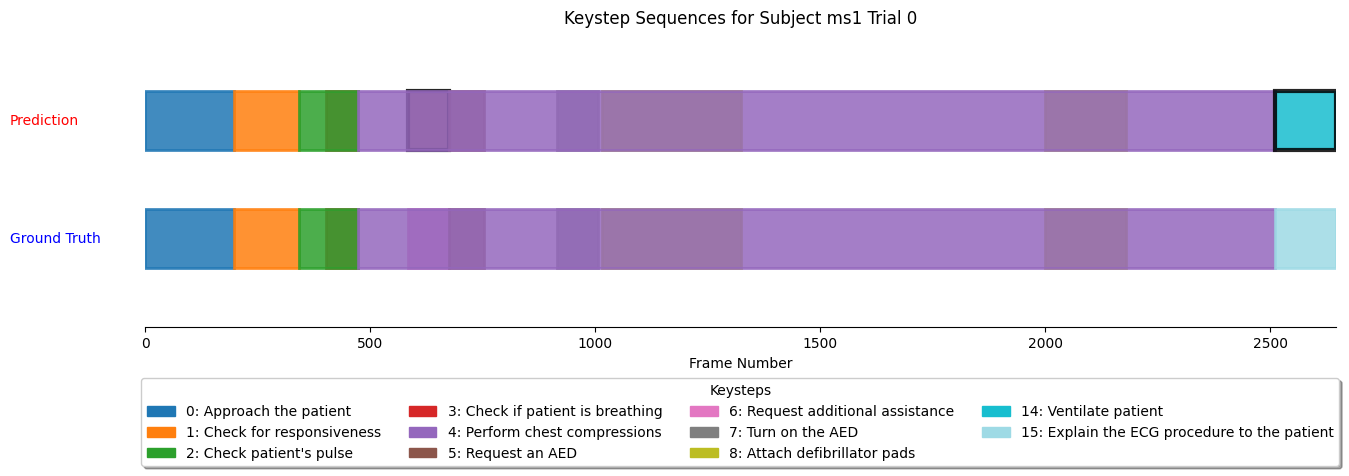

In [113]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

# Function to generate a color map for keystep IDs with distinct colors
def get_unique_colors(num_colors):
    return cm.get_cmap('tab20', num_colors)  # Using 'hsv' for distinct colors

# Function to plot keystep sequences with unique colors and a legend at the bottom
def plot_keystep_sequences(ground_truth, predicted, subject, trial, keystep_dict):
    # Get unique keystep IDs for ground truth and predicted keysteps
    all_keysteps = list(set(ground_truth['keystep_id'].unique()).union(set(predicted['pred_keystep_id'].unique())))
    
    print(len(all_keysteps))
    # Generate a color map with as many unique colors as there are keysteps
    color_map = get_unique_colors(len(all_keysteps))
    color_dict = {keystep_id: color_map(i) for i, keystep_id in enumerate(all_keysteps)}

 
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(14, 5))  # Increased height and width for better spacing

    # Plot ground truth keysteps
    y_pos_gt = 0  # Position for ground truth timeline
    for i, (start, end, keystep_id) in enumerate(zip(ground_truth['start_frame'], ground_truth['end_frame'], ground_truth['keystep_id'])):
        width = max(end - start, 5)  # Ensure a minimum width for short keysteps
        rect = patches.Rectangle((start, y_pos_gt), width, 1, edgecolor=color_dict[keystep_id], facecolor=color_dict[keystep_id], linewidth=2, alpha=0.85)
        ax.add_patch(rect)

    # Plot predicted keysteps with mismatch highlighting
    y_pos_pred = 2  # Increased vertical space between ground truth and prediction
    for i, (start, end, pred_keystep_id) in enumerate(zip(predicted['start_frame'], predicted['end_frame'], predicted['pred_keystep_id'])):
        width = max(end - start, 5)  # Ensure a minimum width for short keysteps
        gt_keystep_id = ground_truth['keystep_id'].iloc[i] if i < len(ground_truth) else None
        if pred_keystep_id != gt_keystep_id:
            # Mismatch: use thicker red boundary
            rect = patches.Rectangle((start, y_pos_pred), width, 1, edgecolor='black', facecolor=color_dict[pred_keystep_id], linewidth=3, alpha=0.85)
        else:
            # Match: use normal boundary color
            rect = patches.Rectangle((start, y_pos_pred), width, 1, edgecolor=color_dict[pred_keystep_id], facecolor=color_dict[pred_keystep_id], linewidth=2, alpha=0.85)
        ax.add_patch(rect)

    # Add labels for the timelines
    ax.text(-300, y_pos_gt + 0.5, 'Ground Truth', va='center', fontsize=10, color='blue')
    ax.text(-300, y_pos_pred + 0.5, 'Prediction', va='center', fontsize=10, color='red')

    # Create a horizontal legend at the bottom
    legend_elements = [patches.Patch(facecolor=color_dict[k], edgecolor=color_dict[k], label=f"{k}: {keystep_dict[k]}") for k in all_keysteps]
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=4, title="Keysteps")

    # Set axis limits and labels
    ax.set_xlim([0, max(ground_truth['end_frame'].max(), predicted['end_frame'].max())])
    ax.set_ylim([-1, 4])
    ax.set_xlabel('Frame Number')
    ax.set_title(f'Keystep Sequences for Subject {subject} Trial {trial}')

    # Hide y-axis
    ax.get_yaxis().set_visible(False)

    # hide top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # save figure
    plt.savefig(f'{results_dir}/subject_{subject}_trial_{trial}_keystep_sequence.png')
    # Show plot
    plt.tight_layout()
    plt.show()





# Example usage with one subject's trial data
for (subject, trial), group in df.groupby(['subject_id', 'trial_id']):
    ground_truth_data = group[['keystep_id', 'start_frame', 'end_frame']]
    predicted_data = group[['pred_keystep_id', 'start_frame', 'end_frame']]


    # Plot using the keystep IDs with unique colors, thicker boundaries, and a horizontal legend
    plot_keystep_sequences(ground_truth_data, predicted_data, subject, trial, keysteps_dict)
    break  # Only plot the first subject's trial for now


/tmp/ipykernel_228443/2255523553.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return cm.get_cmap('tab20', num_colors)  # Using 'hsv' for distinct colors


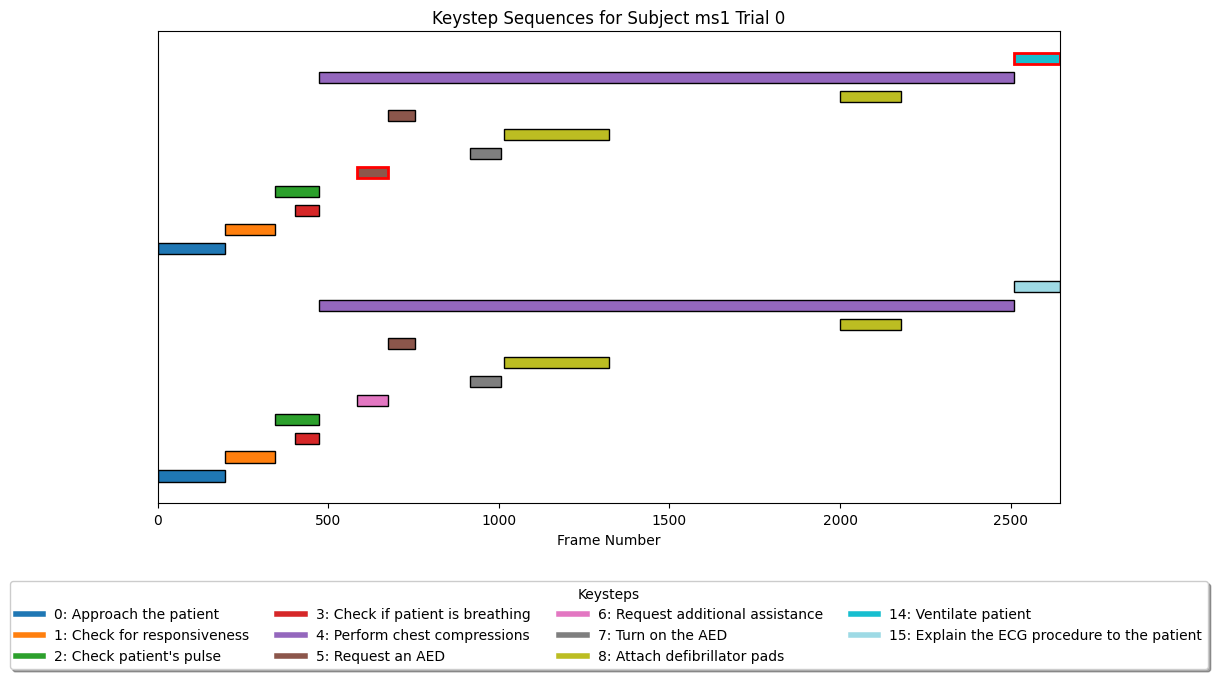

In [62]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Function to generate a color map for keystep IDs with distinct colors
def get_unique_colors(num_colors):
    return cm.get_cmap('tab20', num_colors)  # Using 'hsv' for distinct colors

# Function to plot keystep sequences using horizontal bar plot
def plot_keystep_bars(ground_truth, predicted, subject, trial, keystep_dict):
    # Get unique keystep IDs for ground truth and predicted keysteps
    all_keysteps = list(set(ground_truth['keystep_id'].unique()).union(set(predicted['pred_keystep_id'].unique())))
    
    # Generate a color map with as many unique colors as there are keysteps
    color_map = get_unique_colors(len(all_keysteps))
    color_dict = {keystep_id: color_map(i) for i, keystep_id in enumerate(all_keysteps)}

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 7))  # Increased height for better spacing

    # Plot horizontal bars for ground truth keysteps
    y_pos_gt = 0  # Position for ground truth timeline
    for i, (start, end, keystep_id) in enumerate(zip(ground_truth['start_frame'], ground_truth['end_frame'], ground_truth['keystep_id'])):
        width = max(end - start, 5)  # Ensure a minimum width of 5 for visibility
        ax.barh(y_pos_gt, width, left=start, height=0.6, color=color_dict[keystep_id], edgecolor='black')
        y_pos_gt += 1  # Move to next row for ground truth

    # Plot horizontal bars for predicted keysteps
    y_pos_pred = y_pos_gt + 1  # Leave a gap between ground truth and predicted
    for i, (start, end, pred_keystep_id) in enumerate(zip(predicted['start_frame'], predicted['end_frame'], predicted['pred_keystep_id'])):
        width = max(end - start, 5)  # Ensure a minimum width of 5 for visibility
        if pred_keystep_id != ground_truth['keystep_id'].iloc[i]:
            ax.barh(y_pos_pred, width, left=start, height=0.6, color=color_dict[pred_keystep_id], edgecolor='red', linewidth=2)  # Highlight mismatches
        else:
            ax.barh(y_pos_pred, width, left=start, height=0.6, color=color_dict[pred_keystep_id], edgecolor='black')
        y_pos_pred += 1  # Move to next row for predicted

    # Create a horizontal legend at the bottom
    legend_elements = [plt.Line2D([0], [0], color=color_dict[k], lw=4, label=f"{k}: {keystep_dict[k]}") for k in all_keysteps]
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=4, title="Keysteps")

    # Set axis limits and labels
    ax.set_xlim([0, max(ground_truth['end_frame'].max(), predicted['end_frame'].max())])
    ax.set_yticks([])  # Hide y-axis labels
    ax.set_xlabel('Frame Number')
    ax.set_title(f'Keystep Sequences for Subject {subject} Trial {trial}')

    # Show plot
    plt.tight_layout()
    plt.show()

# Dictionary for keysteps with their natural language descriptions
keysteps_dict = {
    0: "Approach the patient",
    1: "Check for responsiveness",
    2: "Check patient's pulse",
    3: "Check if patient is breathing",
    4: "Perform chest compressions",
    5: "Request an AED",
    6: "Request additional assistance",
    7: "Turn on the AED",
    8: "Attach defibrillator pads",
    9: "Clear for analysis",
    10: "Clear for shock",
    11: "Administer shock using AED",
    12: "Open patient's airway",
    13: "Place bag valve mask (BVM)",
    14: "Ventilate patient",
    15: "Explain the ECG procedure to the patient",
    16: "Prepare the patient for ECG",
    17: "Place the limb leads for ECG",
    18: "Place the V1 lead on the patient",
    19: "Place the V2 lead on the patient",
    20: "Place the V3 lead on the patient",
    21: "Place the V4 lead on the patient",
    22: "Place the V5 lead on the patient",
    23: "Place the V6 lead on the patient",
    24: "Ensure the patient is stable",
    25: "Turn on the ECG machine",
    26: "Verify all ECG leads are properly connected",
    27: "Obtain the ECG recording",
    28: "Examine the ECG trace for quality",
    29: "Interpret the ECG and report findings",
    30: "No action"
}

# Example usage with one subject's trial data
for (subject, trial), group in df.groupby(['subject_id', 'trial_id']):
    ground_truth_data = group[['keystep_id', 'start_frame', 'end_frame']]
    predicted_data = group[['pred_keystep_id', 'start_frame', 'end_frame']]

    # Plot using the keystep IDs with horizontal bar plot and color legend
    plot_keystep_bars(ground_truth_data, predicted_data, subject, trial, keysteps_dict)
    break  # Only plot the first subject's trial for now
